In [1]:
import torch
import torchvision
import torch.nn as nn
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

print(torch.__version__)
print(torchvision.__version__)
torch.__file__

2.3.0+cu121
0.18.0+cu121


'/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/__init__.py'

In [2]:
def get_all_layers(model):
    all_layers = []
    
    def collect_leaves(module, prefix=''):
        for name, child in module.named_children():
            full_name = f"{prefix}.{name}" if prefix else name
            
            if len(list(child.children())) == 0:
                all_layers.append((full_name, child))
            else:
                collect_leaves(child, prefix=full_name)
    
    collect_leaves(model)
    
    return all_layers

In [3]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import mnasnet1_0, MNASNet1_0_Weights
from torchvision.models import googlenet, GoogLeNet_Weights
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights

weights = SqueezeNet1_0_Weights.DEFAULT
model_squeezenet = squeezenet1_0(weights=weights)
model_squeezenet.eval()

weights = GoogLeNet_Weights.DEFAULT
model_googlenet = googlenet(weights=weights)
model_googlenet.eval()

weights = MobileNet_V2_Weights.DEFAULT
model_mobilenet = mobilenet_v2(weights=weights)
model_mobilenet.eval()


weights = MNASNet1_0_Weights.DEFAULT
model_mnasnet = mnasnet1_0(weights=weights)
model_mnasnet.eval()

models = {"squeezenet": model_squeezenet,
         "googlenet": model_googlenet,
         "mobilenet": model_mobilenet,
         "mnasnet": model_mnasnet}

models_original = copy.deepcopy(models)



for name, model in models.items():
    print(f"Model: {name}")
    print(f"Number of modules: {len(list(model.modules()))}")
    print(f"number of leaf layers: {len(get_all_layers(model))} ")
    print("-" * 40)


Model: squeezenet
Number of modules: 68
number of leaf layers: 57 
----------------------------------------
Model: googlenet
Number of modules: 224
number of leaf layers: 130 
----------------------------------------
Model: mobilenet
Number of modules: 213
number of leaf layers: 141 
----------------------------------------
Model: mnasnet
Number of modules: 182
number of leaf layers: 141 
----------------------------------------


In [4]:
class LaLaRAND:
    def __init__(self, model, device_sequence):
        self.model = model
        self.device_sequence = device_sequence
        self.current_device_index = 0
        self.all_layers = self._get_all_layers()
        self.execution_times = {}

        if len(self.device_sequence) != len(self.all_layers):
            raise ValueError("레이어 수와 device 결정 순서 개수가 일치하지 않음")
        self._register_hooks()
        
    def _get_all_layers(self):
        all_layers = []
        
        def recursive_children(module, parent=''):
            for name, child in module.named_children():
                # `parent == False` 버그 수정
                full_name = f"{parent}.{name}" if parent else name
                
                if len(list(child.children())) == 0:
                    all_layers.append((full_name, child))
                else:
                    recursive_children(child, parent=full_name)
        recursive_children(self.model)

        return all_layers
    
    def _register_hooks(self):

        for i, (layer_name, layer) in enumerate(self.all_layers):
            device_type = self.device_sequence[i]

            # Pre-hook: 레이어와 입력을 같은 device로 이동
            def make_pre_hook(idx, name, dev_type):
                def pre_hook(module, input):
                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 

                    input_memory_transfer_start_time = time.time()

                    # Target device 결정
                    if dev_type == 0:
                        target_device = 'cpu'
                    else:
                        target_device = 'cuda'  
                    
                    # 레이어를 target device로 이동
                    module.to(target_device)
                    
                    if isinstance(input, tuple):
                        result = []
                        for inp in input:
                            result.append(inp.to(target_device))  
                        input = tuple(result)  
                    else: 
                        input = input.to(target_device)

                    input_memory_transfer_end_time = time.time()
                    input_memory_transfer_time = (input_memory_transfer_end_time - input_memory_transfer_start_time) * 1000
                    
                    device_name = "CPU" if dev_type == 0 else "GPU"
                    self.execution_times[f"Layer_{idx:03d}_{name}_input_memory_transfer"] = {
                        'time_ms': input_memory_transfer_time, 
                        'device': device_name
                    }  
                    
                    module._start_time = time.time()
                    self.current_device_index += 1
                    return input
                
                return pre_hook
            
            # Post-hook: end_time 측정 및 output을 target_device로 이동
            def make_post_hook(idx, name, dev_type):
                def post_hook(module, input, output):
                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 

                    module._end_time = time.time()
                    execution_time = (module._end_time - module._start_time) * 1000
                    self.execution_times[f"Layer_{idx:03d}_{name}_execution_time"] = {
                        'time_ms': execution_time, 
                        'device': dev_type
                    }
                    
                    output_memory_transfer_start_time = time.time()
                    output = output.to('cuda')
                    output_memory_transfer_end_time = time.time()
                    output_memory_transfer_time = (output_memory_transfer_end_time - output_memory_transfer_start_time) * 1000
                    
                    self.execution_times[f"Layer_{idx:03d}_{name}_output_memory_transfer"] = {
                        'time_ms': output_memory_transfer_time, 
                        'device': dev_type
                    }

                    return output

                return post_hook
            
            # Hook 등록 및 handle 저장
            pre_handle = layer.register_forward_pre_hook(make_pre_hook(i, layer_name, device_type))
            post_handle = layer.register_forward_hook(make_post_hook(i, layer_name, device_type))
        
    def forward(self, x):


        # 실행 시간 및 인덱스 초기화
        self.execution_times.clear()
        self.current_device_index = 0
        
        x = x.to("cuda")
        
        self.model.eval()
        with torch.inference_mode():
            output = self.model(x)
            output = output.to("cuda") 
        
        return output

In [ ]:
class LaLaRAND_v2:
    def __init__(self, model, resource_selector):
        self.model = model
        self.all_layers = self._get_all_layers()
        self.execution_times = {}
        self.resource_selector = resource_selector
        self._register_hooks()

    def _get_all_layers(self):
        all_layers = []
        
        def recursive_children(module, parent=''):
            for name, child in module.named_children():
                if parent == True:
                    full_name = f"{parent}.{name}" 
                else:
                    full_name = name
                
                if len(list(child.children())) == 0:
                    all_layers.append((full_name, child))
                else:
                    recursive_children(child, parent=full_name)
        recursive_children(self.model)

        return all_layers
    
    def _register_hooks(self):

        for i, (layer_name, layer) in enumerate(self.all_layers):
            # Pre-hook: 레이어와 입력을 같은 device로 이동
            def make_pre_hook(idx, name):
                def pre_hook(module, input):
                    
                    target_device = self.resource_selector(idx)
                    module._target_device = target_device

                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 
                    
                    module_transfer_start_time = time.time()
                    # 레이어를 target device로 이동
                    module.to(target_device)
                    module_transfer_end_time = time.time()
                    
                    input_transfer_start_time = time.time()
                    if isinstance(input, tuple):
                        result = []
                        for inp in input:
                            result.append(inp.to(target_device))  
                        input = tuple(result)  
                    else: 
                        input = input.to(target_device)
                    input_transfer_end_time = time.time()

                    
                    module_transfer_time = (module_transfer_end_time - module_transfer_start_time) * 1000
                    self.execution_times[f"Layer_{idx:03d}_{name}_module_transfer"] = {
                        'time_ms': module_transfer_time, 
                        'device': target_device
                    }

                    input_transfer_time = (input_transfer_end_time - input_transfer_start_time) * 1000
                    self.execution_times[f"Layer_{idx:03d}_{name}_input_transfer"] = {
                        'time_ms': input_transfer_time, 
                        'device': target_device
                    }  
                    
                    module._start_time = time.time()
                    return input
                
                return pre_hook
            
            # Post-hook: end_time 측정 및 output을 target_device로 이동
            def make_post_hook(idx, name):
                def post_hook(module, input, output):
                    target_device = module._target_device

                    if torch.cuda.is_available():
                        torch.cuda.synchronize() 

                    module._end_time = time.time()
                    execution_time = (module._end_time - module._start_time) * 1000
                    self.execution_times[f"Layer_{idx:03d}_{name}_execution_time"] = {
                        'time_ms': execution_time, 
                        'device': target_device
                    }
                    output = output.to("cuda")
                    return output
                return post_hook
            
            # Hook 등록 및 handle 저장
            layer.register_forward_pre_hook(make_pre_hook(i, layer_name))
            layer.register_forward_hook(make_post_hook(i, layer_name))
        
    def forward(self, x):

        # 실행 시간 및 인덱스 초기화
        self.execution_times.clear()        
        x = x.to("cuda")
        
        self.model.eval()
        with torch.inference_mode():
            output = self.model(x)
            output = output.to("cuda") 
        
        return output

In [6]:
def resource_decider(layer_index):

    return "cpu"

def resource_decider_gpu(layer_index):

    return "cuda"

def resource_decider_cpu(layer_index):

    return "cpu"

In [7]:
dummy_gpu = torch.randn(1000, 3, 224, 224, device="cuda")
dummy_cpu = dummy_gpu.cpu()

simple_results = {}
for name, model in models.items():
    # --- GPU ---
    m_gpu = copy.deepcopy(model).eval().to("cuda")
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.inference_mode():
        _ = m_gpu(dummy_gpu)
    torch.cuda.synchronize()
    t1 = time.time()
    simple_results[name] = {'gpu': t1-t0}

    # --- GPU with LaLaRAND ---
    #lala_gpu = LaLaRAND(copy.deepcopy(model), [1] * len(get_all_layers(model)))
    lala_gpu = LaLaRAND_v2(copy.deepcopy(model), resource_decider_gpu)
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.inference_mode():
        _ = lala_gpu.forward(dummy_gpu)
    torch.cuda.synchronize()
    t1 = time.time()
    simple_results[name]['lala_gpu'] = t1-t0

    # --- CPU ---
    m_cpu = copy.deepcopy(model).eval().to("cpu")
    t2 = time.time()
    with torch.inference_mode():
        _ = m_cpu(dummy_cpu)
    t3 = time.time()
    simple_results[name]['cpu'] = t3-t2

     # --- CPU with LaLaRAND ---
    #lala_cpu = LaLaRAND(copy.deepcopy(model), [0] * len(get_all_layers(model)))
    lala_cpu = LaLaRAND_v2(copy.deepcopy(model), resource_decider_cpu)
    t0 = time.time()
    with torch.inference_mode():
        _ = lala_cpu.forward(dummy_cpu)
    t1 = time.time()
    simple_results[name]['lala_cpu'] = t1-t0

/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


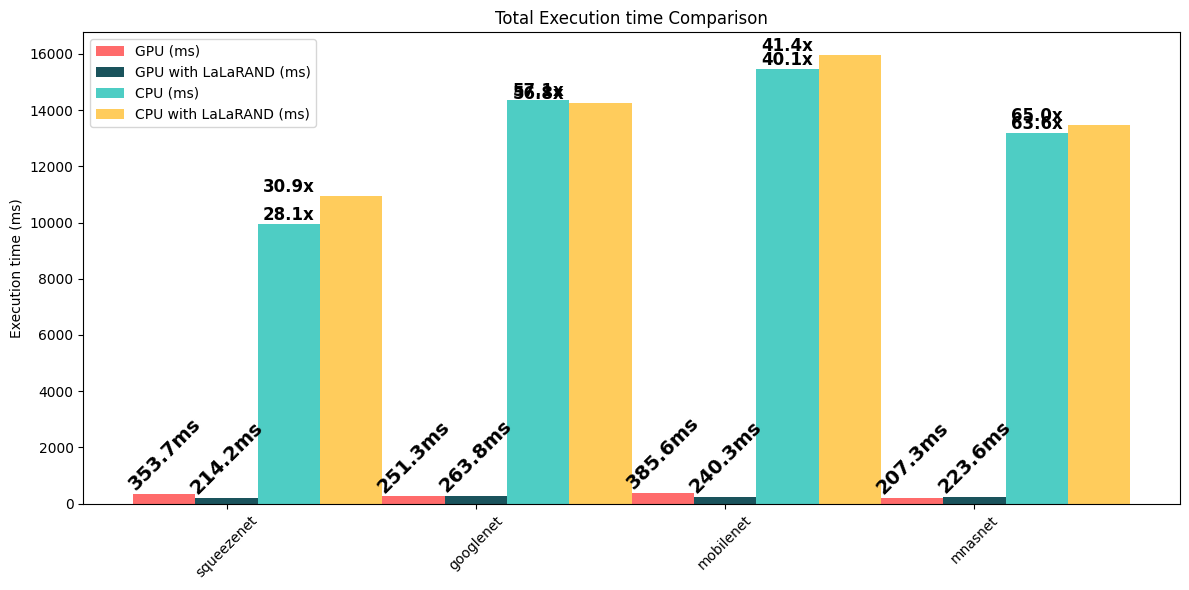

In [8]:
# ---------- Plot ----------
model_names = list(simple_results.keys())
gpu_times   = [simple_results[k]['gpu']*1000 for k in model_names]
lala_gpu_times = [simple_results[k]['lala_gpu']*1000 for k in model_names]
cpu_times   = [simple_results[k]['cpu']*1000 for k in model_names]
lala_cpu_times = [simple_results[k]['lala_cpu']*1000 for k in model_names]


x = np.arange(len(model_names))
w = 0.25  # 막대 폭을 줄여서 3개 막대가 잘 보이도록

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - w, gpu_times, width=w, label='GPU (ms)', color='#ff6b6b')
bars2 = plt.bar(x, lala_gpu_times, width=w, label='GPU with LaLaRAND (ms)', color='#1a535c')
bars3 = plt.bar(x + w, cpu_times, width=w, label='CPU (ms)', color='#4ecdc4')
bars4 = plt.bar(x + 2*w, lala_cpu_times, width=w, label='CPU with LaLaRAND (ms)', color='#ffcc5c')

# GPU 실행 시간 라벨 달기
for i, (bar, gpu_time) in enumerate(zip(bars1, gpu_times)):
    height = bar.get_height()
    plt.text(x[i] - w, height*1.02, f"{gpu_time:.1f}ms",
             ha='center', va='bottom', fontsize=14, fontweight='bold', rotation=45)

# GPU with LaLaRAND 실행 시간 라벨 달기
for i, (bar, lala_gpu_time) in enumerate(zip(bars2, lala_gpu_times)):
    height = bar.get_height()
    plt.text(x[i], height*1.02, f"{lala_gpu_time:.1f}ms",
             ha='center', va='bottom', fontsize=14, fontweight='bold', rotation = 45)

# CPU 실행 시간 라벨 달기
for i, (bar, cpu_time) in enumerate(zip(bars3, cpu_times)):
    cpu_vs_gpu_slowdown = cpu_times[i] / gpu_times[i]
    height = bar.get_height()
    plt.text(x[i] + w, height*1., f"{cpu_vs_gpu_slowdown:.1f}x",
             ha='center', va='bottom', fontsize=12, fontweight='bold',)
    
# CPU with lalarand 실행 시간 라벨 달기
for i, (bar, cpu_time) in enumerate(zip(bars4, lala_cpu_times)):
    lala_cpu_vs_gpu_slowdown = lala_cpu_times[i] / gpu_times[i]
    height = bar.get_height()
    plt.text(x[i] + w, height*1., f"{lala_cpu_vs_gpu_slowdown:.1f}x",
             ha='center', va='bottom', fontsize=12, fontweight='bold',)

    
plt.xticks(x, model_names, rotation=45)
plt.ylabel('Execution time (ms)')
plt.title('Total Execution time Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
results = {}
dummy_input = torch.randn(1000, 3, 224, 224).cuda()
for name, model in models.items():
    print(f"\n🔍 Processing {name}...")
    
    
    num_layers = len(get_all_layers(model))
    
    # GPU 실행
    #gpu_config = [1] * num_layers
    #gpu_model = LaLaRAND(copy.deepcopy(model), gpu_config)
    #_ = gpu_model.forward(dummy_input)

    # GPU with LaLaRAND v2
    gpu_model = LaLaRAND_v2(copy.deepcopy(model), resource_decider_gpu)
    _ = gpu_model.forward(dummy_input) 

    
    # CPU 실행
    #cpu_config = [0] * num_layers
    #cpu_model = LaLaRAND(copy.deepcopy(model), cpu_config)
    #_ = cpu_model.forward(dummy_input)

    # CPU with LaLaRAND v2
    cpu_model = LaLaRAND_v2(copy.deepcopy(model), resource_decider_cpu)
    _ = cpu_model.forward(dummy_input)
    
    # 실행 시간만 추출
    # execution_times 전체를 저장 (딕셔너리로)
    results[name] = {
        'gpu': gpu_model.execution_times,
        'cpu': cpu_model.execution_times
    }
    print(f"✅ {name} completed!")


🔍 Processing squeezenet...
✅ squeezenet completed!

🔍 Processing googlenet...
✅ googlenet completed!

🔍 Processing mobilenet...
✅ mobilenet completed!

🔍 Processing mnasnet...
✅ mnasnet completed!


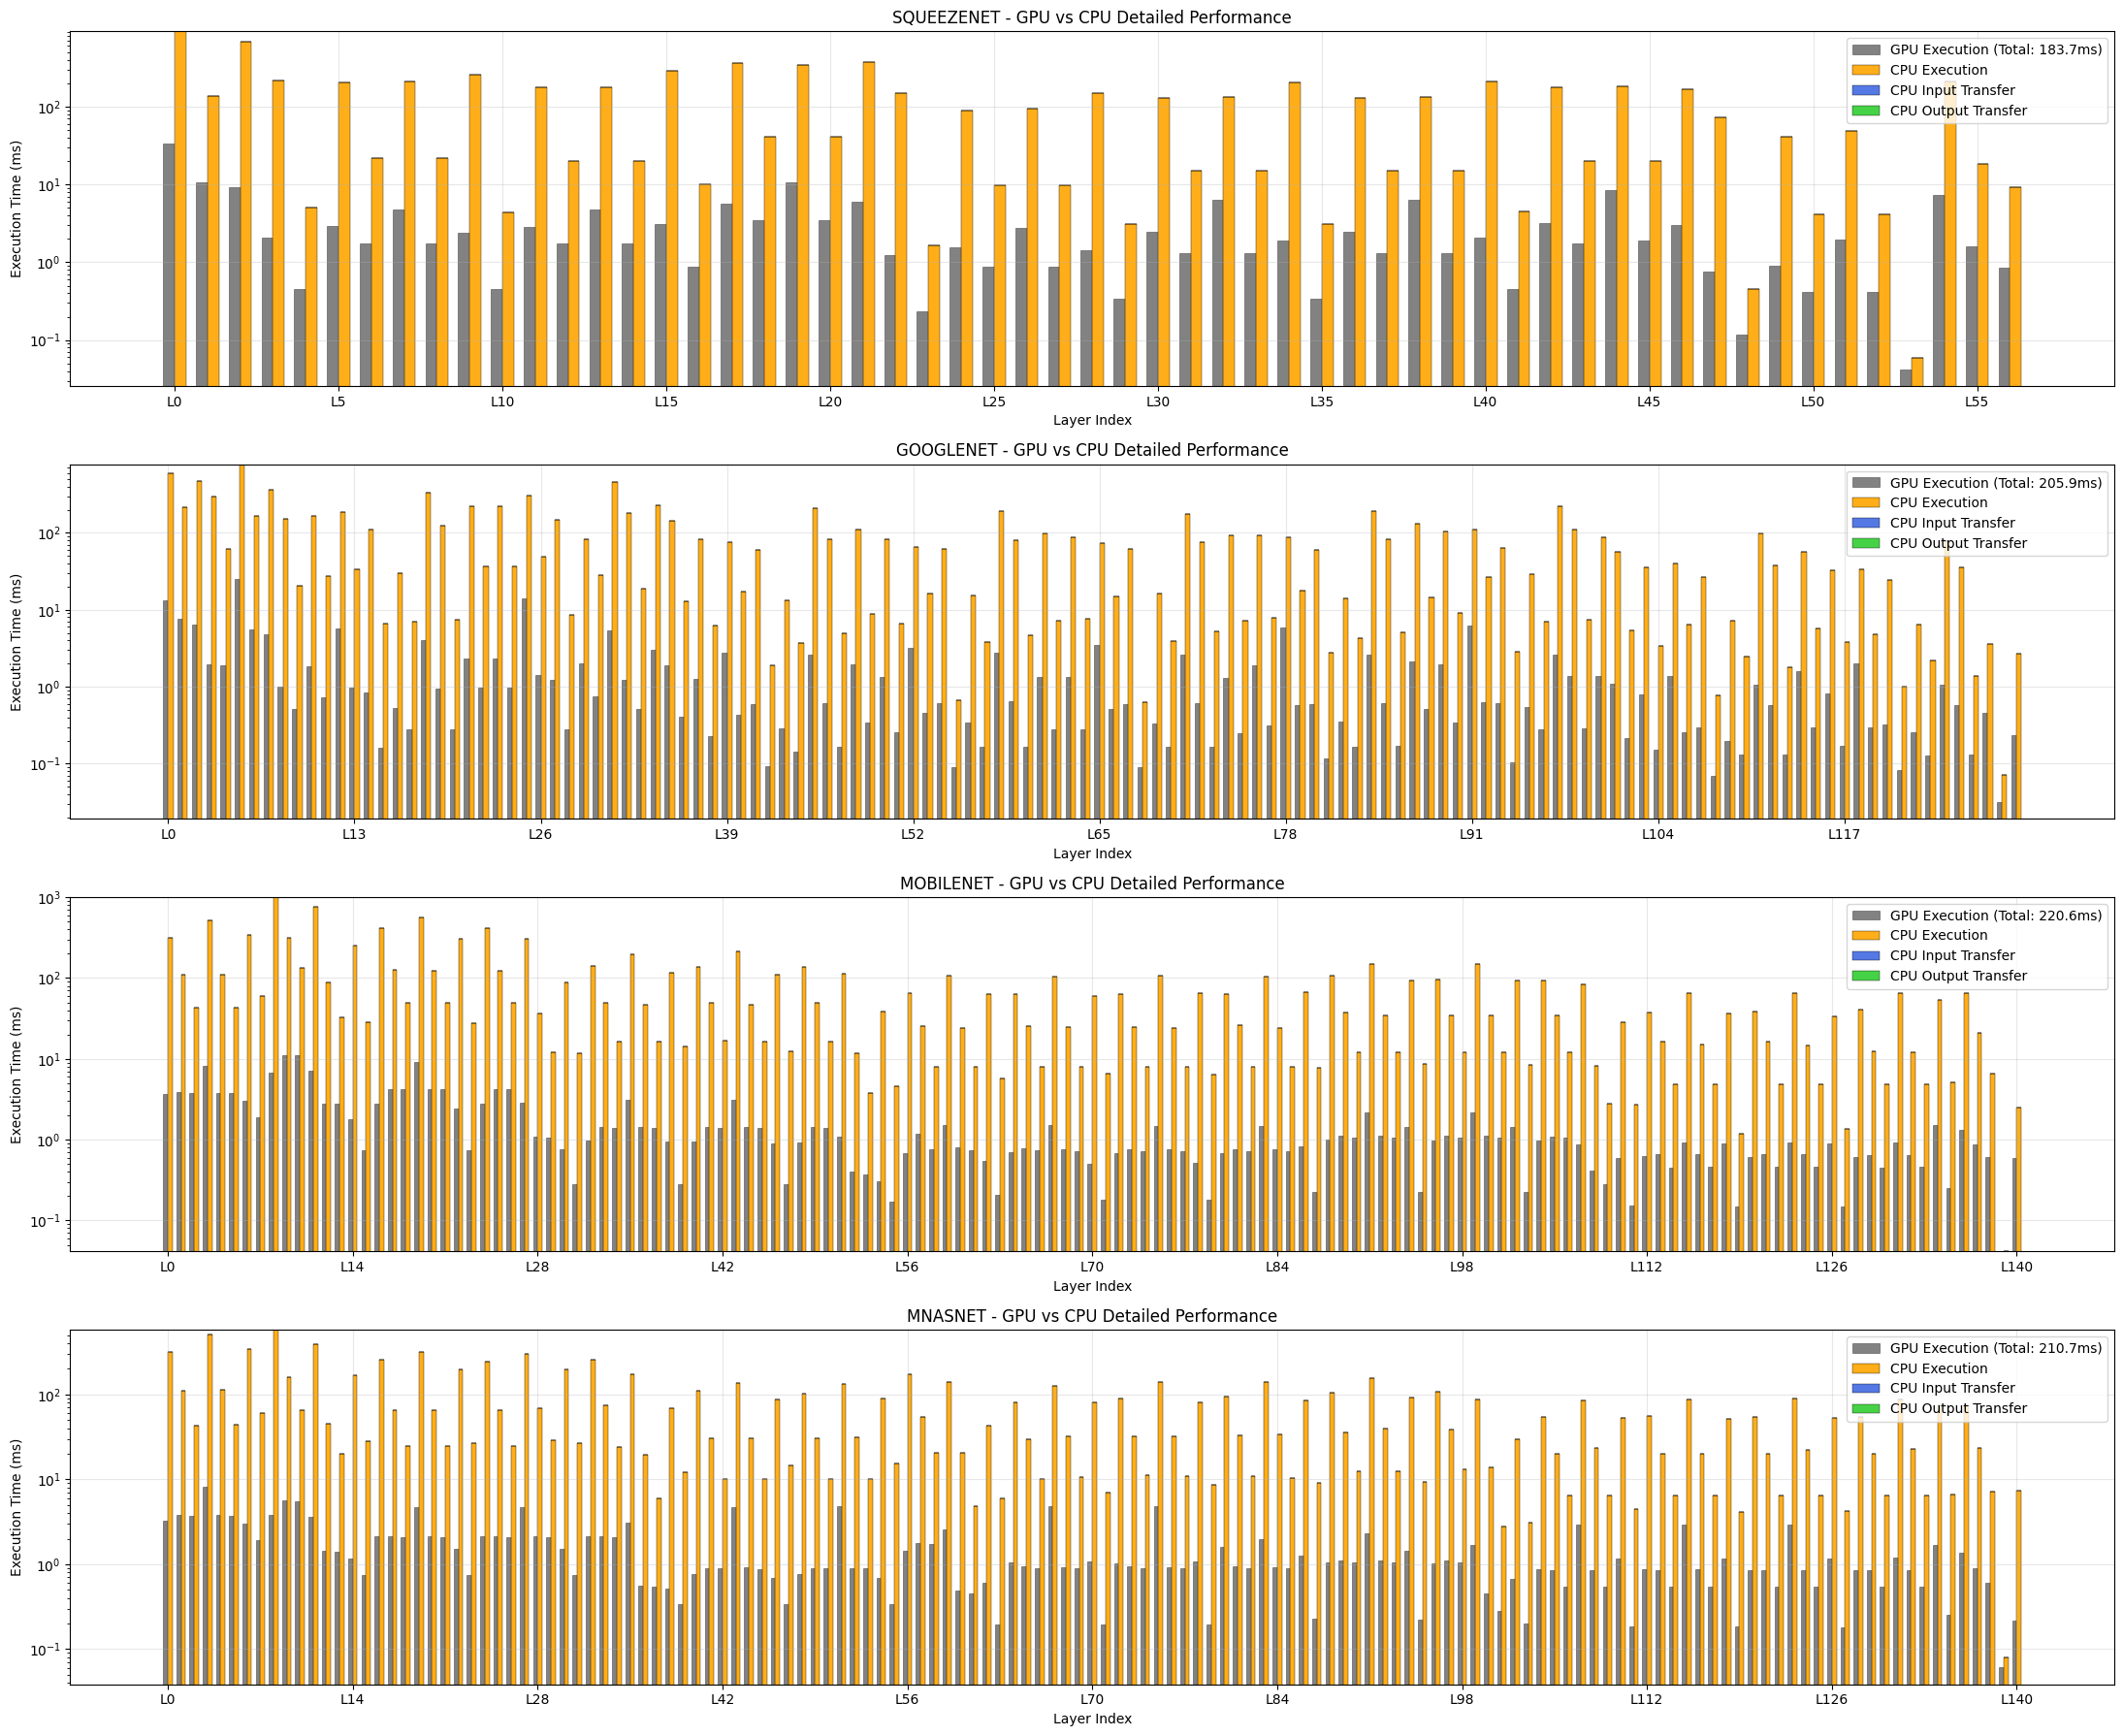


💾 Results saved to: /workspace/pytorch_bootcamp/results/stacked_comparison_20250725_082948.png
✅ Stacked analysis completed!


In [10]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

fig, axes = plt.subplots(4, 1, figsize=(22, 18))

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx] if len(results) > 1 else axes[0]
    
    # 실행 시간 추출
    gpu_exec_times = []
    cpu_input_times = []
    cpu_exec_times = []
    cpu_output_times = []
    layer_names = []
    
    # 데이터 추출 - 순서대로 정렬
    layer_data = {}
    
    # GPU 실행 시간 추출
    for key, value in data['gpu'].items():
        if 'execution_time' in key:
            layer_idx = int(key.split('_')[1])
            layer_data[layer_idx] = layer_data.get(layer_idx, {})
            layer_data[layer_idx]['gpu_exec'] = value['time_ms']
    
    # CPU 시간 추출 (input, execution, output)
    for key, value in data['cpu'].items():
        layer_idx = int(key.split('_')[1])
        layer_data[layer_idx] = layer_data.get(layer_idx, {})
        
        if 'input_memory_transfer' in key:
            layer_data[layer_idx]['cpu_input'] = value['time_ms']
        elif 'execution_time' in key:
            layer_data[layer_idx]['cpu_exec'] = value['time_ms']
        elif 'output_memory_transfer' in key:
            layer_data[layer_idx]['cpu_output'] = value['time_ms']
    
    # 순서대로 정렬하여 리스트 생성
    for layer_idx in sorted(layer_data.keys()):
        data_point = layer_data[layer_idx]
        gpu_exec_times.append(data_point.get('gpu_exec', 0))
        cpu_input_times.append(data_point.get('cpu_input', 0))
        cpu_exec_times.append(data_point.get('cpu_exec', 0))
        cpu_output_times.append(data_point.get('cpu_output', 0))
        layer_names.append(f"L{layer_idx}")
    
    # 총 실행 시간 계산
    gpu_total_time = sum(gpu_exec_times)
    
    # 막대 그래프
    x = np.arange(len(layer_names))
    width = 0.35
    
    # GPU는 단일 막대 
    bars1 = ax.bar(x - width/2, gpu_exec_times, width, label=f'GPU Execution (Total: {gpu_total_time:.1f}ms)', 
                    color="#070707", alpha=0.5, edgecolor='black', linewidth=0.5)

    # CPU 스택 막대 
    bars2 = ax.bar(x + width/2, cpu_exec_times, width, label='CPU Execution', 
                    color='#FFA500', alpha=0.9, edgecolor='black', linewidth=0.3) 
    bars3 = ax.bar(x + width/2, cpu_input_times, width, bottom=cpu_exec_times, 
                    label='CPU Input Transfer', color='#4169E1', alpha=0.9, edgecolor='black', linewidth=0.3)  
    bars4 = ax.bar(x + width/2, cpu_output_times, width, 
                    bottom=np.array(cpu_input_times) + np.array(cpu_exec_times), label='CPU Output Transfer', color='#32CD32', alpha=0.9, edgecolor='black', linewidth=0.3)

    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - GPU vs CPU Detailed Performance')
    ax.set_xticks(x[::max(1, len(x)//10)])  # x축 라벨 간소화
    ax.set_xticklabels([layer_names[i] for i in range(0, len(layer_names), max(1, len(x)//10))])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # 로그 스케일
    
plt.tight_layout()

# 저장 및 표시
save_path = f'/workspace/pytorch_bootcamp/results/stacked_comparison_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print(f"\n💾 Results saved to: {save_path}")
print("✅ Stacked analysis completed!")



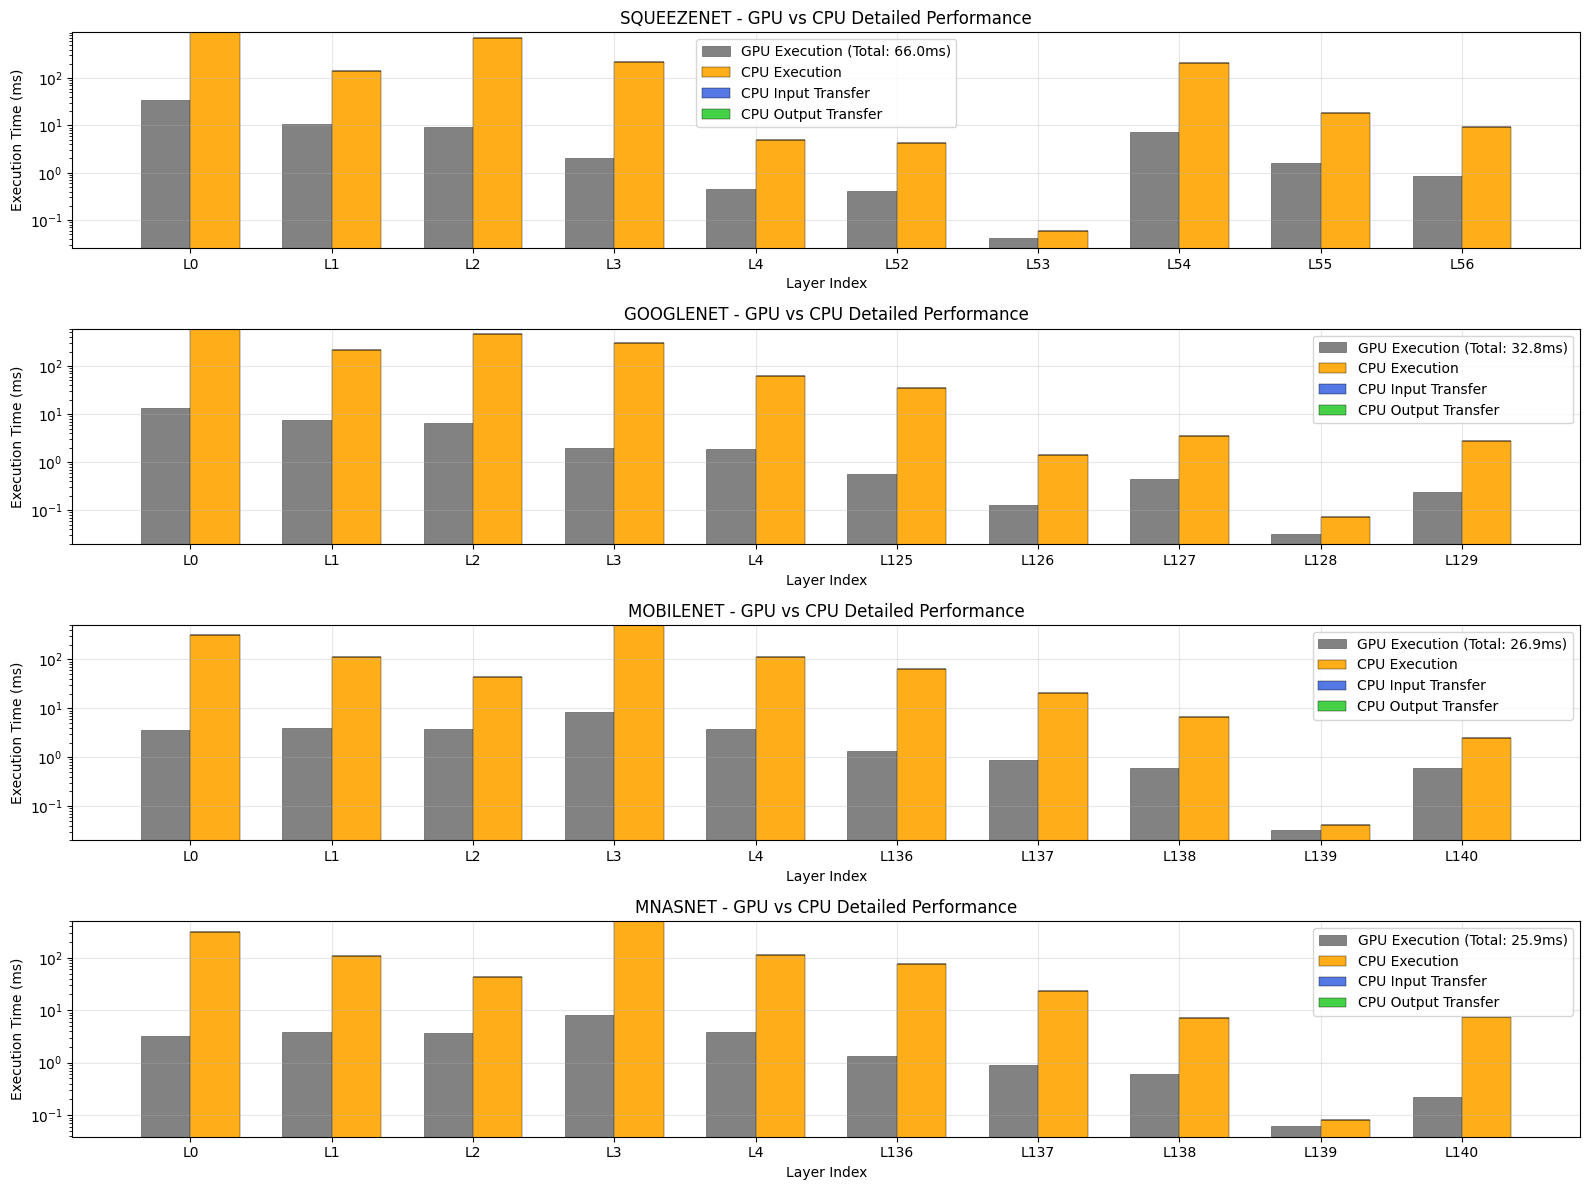


💾 Results saved to: /workspace/pytorch_bootcamp/results/stacked_comparison_20_20250725_082957.png
✅ Stacked analysis completed!


In [11]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx] if len(results) > 1 else axes[0]
    
    # 실행 시간 추출
    gpu_exec_times = []
    cpu_input_times = []
    cpu_exec_times = []
    cpu_output_times = []
    layer_names = []
    
    # 데이터 추출 - 순서대로 정렬
    layer_data = {}
    
    # GPU 실행 시간 추출
    for key, value in data['gpu'].items():
        if 'execution_time' in key:
            layer_idx = int(key.split('_')[1])
            layer_data[layer_idx] = layer_data.get(layer_idx, {})
            layer_data[layer_idx]['gpu_exec'] = value['time_ms']
    
    # CPU 시간 추출 (input, execution, output)
    for key, value in data['cpu'].items():
        layer_idx = int(key.split('_')[1])
        layer_data[layer_idx] = layer_data.get(layer_idx, {})
        
        if 'input_memory_transfer' in key:
            layer_data[layer_idx]['cpu_input'] = value['time_ms']
        elif 'execution_time' in key:
            layer_data[layer_idx]['cpu_exec'] = value['time_ms']
        elif 'output_memory_transfer' in key:
            layer_data[layer_idx]['cpu_output'] = value['time_ms']
    
    # 순서대로 정렬하여 리스트 생성 (처음 5개 + 마지막 5개만)
    sorted_indices = sorted(layer_data.keys())

    # 처음 5개 + 마지막 5개 인덱스 추출
    selected_indices = sorted_indices[:5] + sorted_indices[-5:] if len(sorted_indices) > 10 else sorted_indices

    # 해당 인덱스에 대해만 그래프 데이터 저장
    for layer_idx in selected_indices:
        data_point = layer_data[layer_idx]
        gpu_exec_times.append(data_point.get('gpu_exec', 0))
        cpu_input_times.append(data_point.get('cpu_input', 0))
        cpu_exec_times.append(data_point.get('cpu_exec', 0))
        cpu_output_times.append(data_point.get('cpu_output', 0))
        layer_names.append(f"L{layer_idx}")
    
    # 총 실행 시간 계산
    gpu_total_time = sum(gpu_exec_times)
    
    # 막대 그래프
    x = np.arange(len(layer_names))
    width = 0.35
    
    # GPU는 단일 막대 
    bars1 = ax.bar(x - width/2, gpu_exec_times, width, label=f'GPU Execution (Total: {gpu_total_time:.1f}ms)', 
                    color="#070707", alpha=0.5, edgecolor='black', linewidth=0.5)

    # CPU 스택 막대 
    bars2 = ax.bar(x + width/2, cpu_exec_times, width, label='CPU Execution', 
                    color='#FFA500', alpha=0.9, edgecolor='black', linewidth=0.3) 
    bars3 = ax.bar(x + width/2, cpu_input_times, width, bottom=cpu_exec_times, 
                    label='CPU Input Transfer', color='#4169E1', alpha=0.9, edgecolor='black', linewidth=0.3)  
    bars4 = ax.bar(x + width/2, cpu_output_times, width, 
                    bottom=np.array(cpu_input_times) + np.array(cpu_exec_times), label='CPU Output Transfer', color='#32CD32', alpha=0.9, edgecolor='black', linewidth=0.3)

    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - GPU vs CPU Detailed Performance')
    ax.set_xticks(x[::max(1, len(x)//10)])  # x축 라벨 간소화
    ax.set_xticklabels([layer_names[i] for i in range(0, len(layer_names), max(1, len(x)//10))])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # 로그 스케일
    
plt.tight_layout()

# 저장 및 표시
save_path = f'/workspace/pytorch_bootcamp/results/stacked_comparison_20_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print(f"\n💾 Results saved to: {save_path}")
print("✅ Stacked analysis completed!")



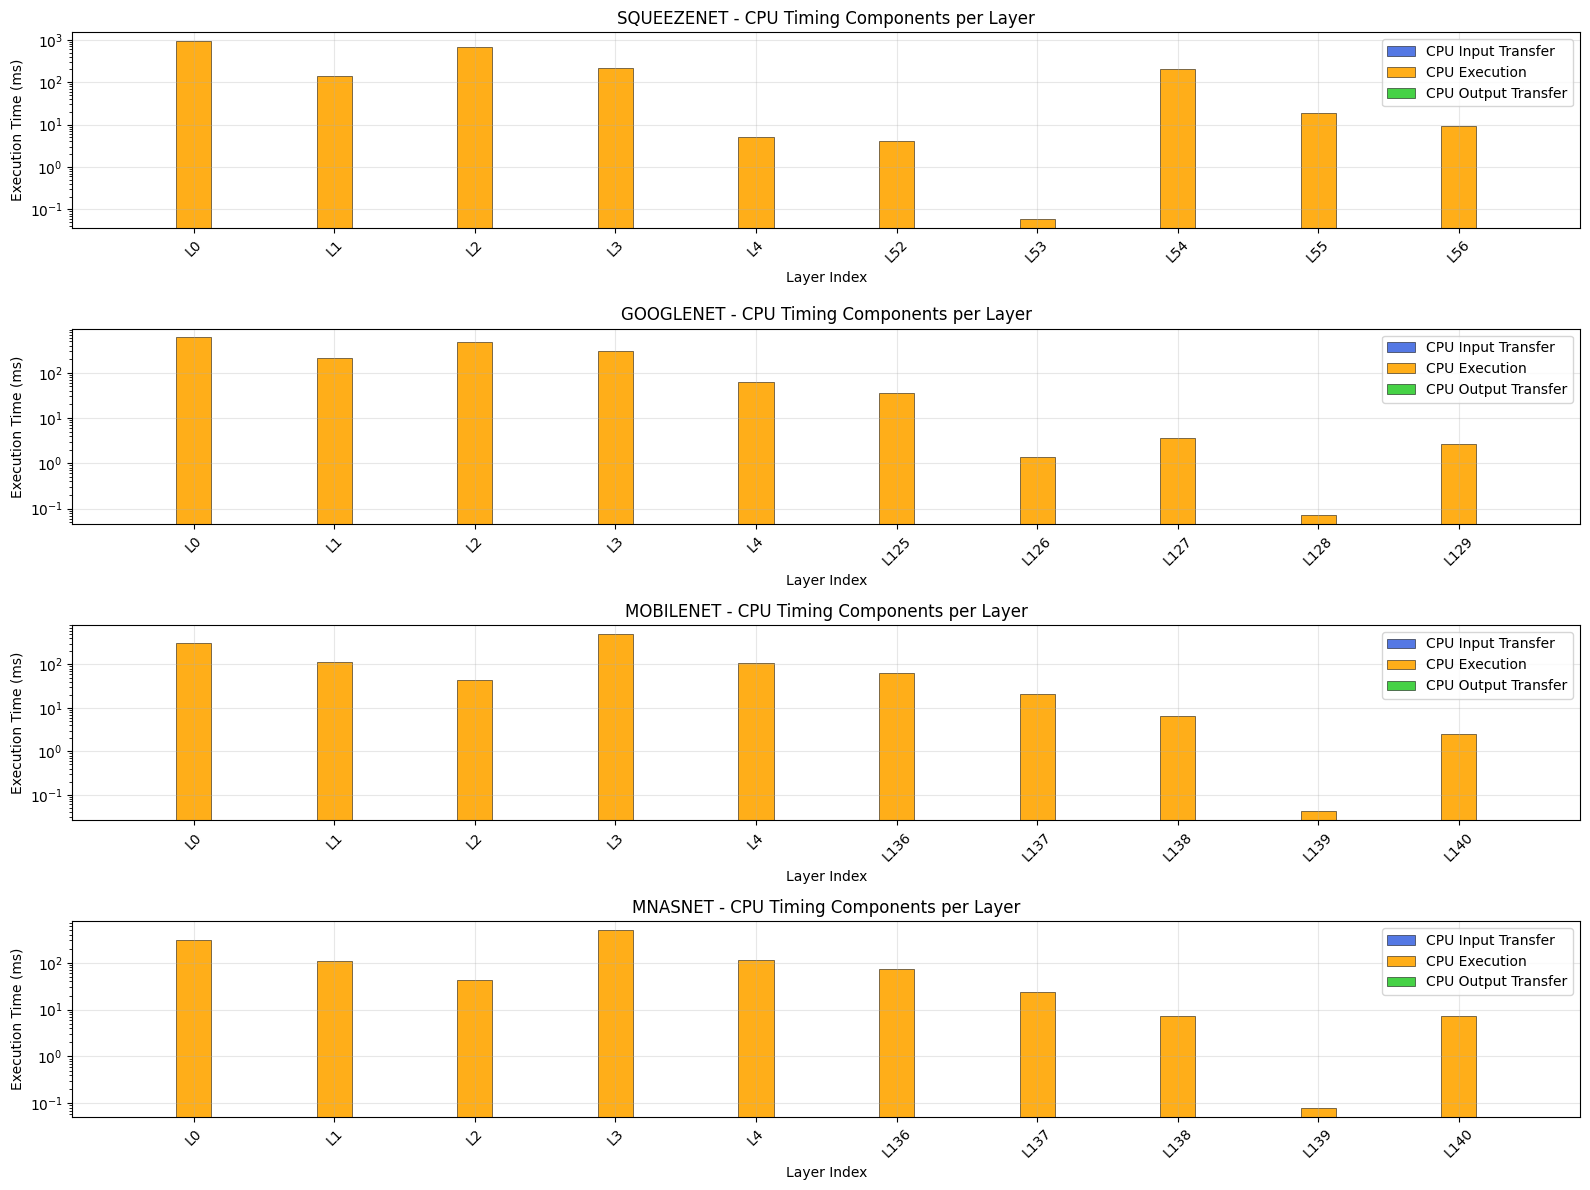

In [12]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx] if len(results) > 1 else axes[0]
    
    # 실행 시간 추출
    gpu_exec_times = []
    cpu_input_times = []
    cpu_exec_times = []
    cpu_output_times = []
    layer_names = []
    
    # 데이터 추출 - 순서대로 정렬
    layer_data = {}
    
    # GPU 실행 시간 추출
    for key, value in data['gpu'].items():
        if 'execution_time' in key:
            layer_idx = int(key.split('_')[1])
            layer_data[layer_idx] = layer_data.get(layer_idx, {})
            layer_data[layer_idx]['gpu_exec'] = value['time_ms']
    
    # CPU 시간 추출 (input, execution, output)
    for key, value in data['cpu'].items():
        layer_idx = int(key.split('_')[1])
        layer_data[layer_idx] = layer_data.get(layer_idx, {})
        
        if 'input_memory_transfer' in key:
            layer_data[layer_idx]['cpu_input'] = value['time_ms']
        elif 'execution_time' in key:
            layer_data[layer_idx]['cpu_exec'] = value['time_ms']
        elif 'output_memory_transfer' in key:
            layer_data[layer_idx]['cpu_output'] = value['time_ms']
    
    # 순서대로 정렬하여 리스트 생성 (처음 5개 + 마지막 5개만)
    sorted_indices = sorted(layer_data.keys())

    # 처음 5개 + 마지막 5개 인덱스 추출
    selected_indices = sorted_indices[:5] + sorted_indices[-5:] if len(sorted_indices) > 10 else sorted_indices

    # 해당 인덱스에 대해만 그래프 데이터 저장
    for layer_idx in selected_indices:
        data_point = layer_data[layer_idx]
        gpu_exec_times.append(data_point.get('gpu_exec', 0))
        cpu_input_times.append(data_point.get('cpu_input', 0))
        cpu_exec_times.append(data_point.get('cpu_exec', 0))
        cpu_output_times.append(data_point.get('cpu_output', 0))
        layer_names.append(f"L{layer_idx}")
    
    # 총 실행 시간 계산
    gpu_total_time = sum(gpu_exec_times)
        
    # 막대 그래프
    x = np.arange(len(layer_names))
    width = 0.25  # 각 막대 너비

    # CPU 막대 그래프 (각 항목 별 그룹 막대)
    bars_input = ax.bar(x - width, cpu_input_times, width, label='CPU Input Transfer', 
                        color='#4169E1', alpha=0.9, edgecolor='black', linewidth=0.4)
    bars_exec = ax.bar(x, cpu_exec_times, width, label='CPU Execution', 
                        color='#FFA500', alpha=0.9, edgecolor='black', linewidth=0.4)
    bars_output = ax.bar(x + width, cpu_output_times, width, label='CPU Output Transfer', 
                        color='#32CD32', alpha=0.9, edgecolor='black', linewidth=0.4)

    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - CPU Timing Components per Layer')
    ax.set_xticks(x)
    ax.set_xticklabels(layer_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # 로그 스케일

plt.tight_layout()



In [22]:
results = {}
dummy_input = torch.randn(1000, 3, 224, 224).cuda()
for name, model in models.items():
    print(f"\n🔍 Processing {name}...")
    
    num_layers = len(get_all_layers(model))

    # GPU with LaLaRAND v2
    gpu_model = LaLaRAND_v2(copy.deepcopy(model).cuda(), resource_decider_gpu)
    _ = gpu_model.forward(dummy_input) 

    # CPU with LaLaRAND v2
    cpu_model = LaLaRAND_v2(copy.deepcopy(model).cuda(), resource_decider_cpu)
    _ = cpu_model.forward(dummy_input)
    
    # 실행 시간만 추출
    # execution_times 전체를 저장 (딕셔너리로)
    results[name] = {
        'gpu': gpu_model.execution_times,
        'cpu': cpu_model.execution_times
    }
    print(f"✅ {name} completed!")


🔍 Processing squeezenet...
✅ squeezenet completed!

🔍 Processing googlenet...
✅ googlenet completed!

🔍 Processing mobilenet...
✅ mobilenet completed!

🔍 Processing mnasnet...
✅ mnasnet completed!


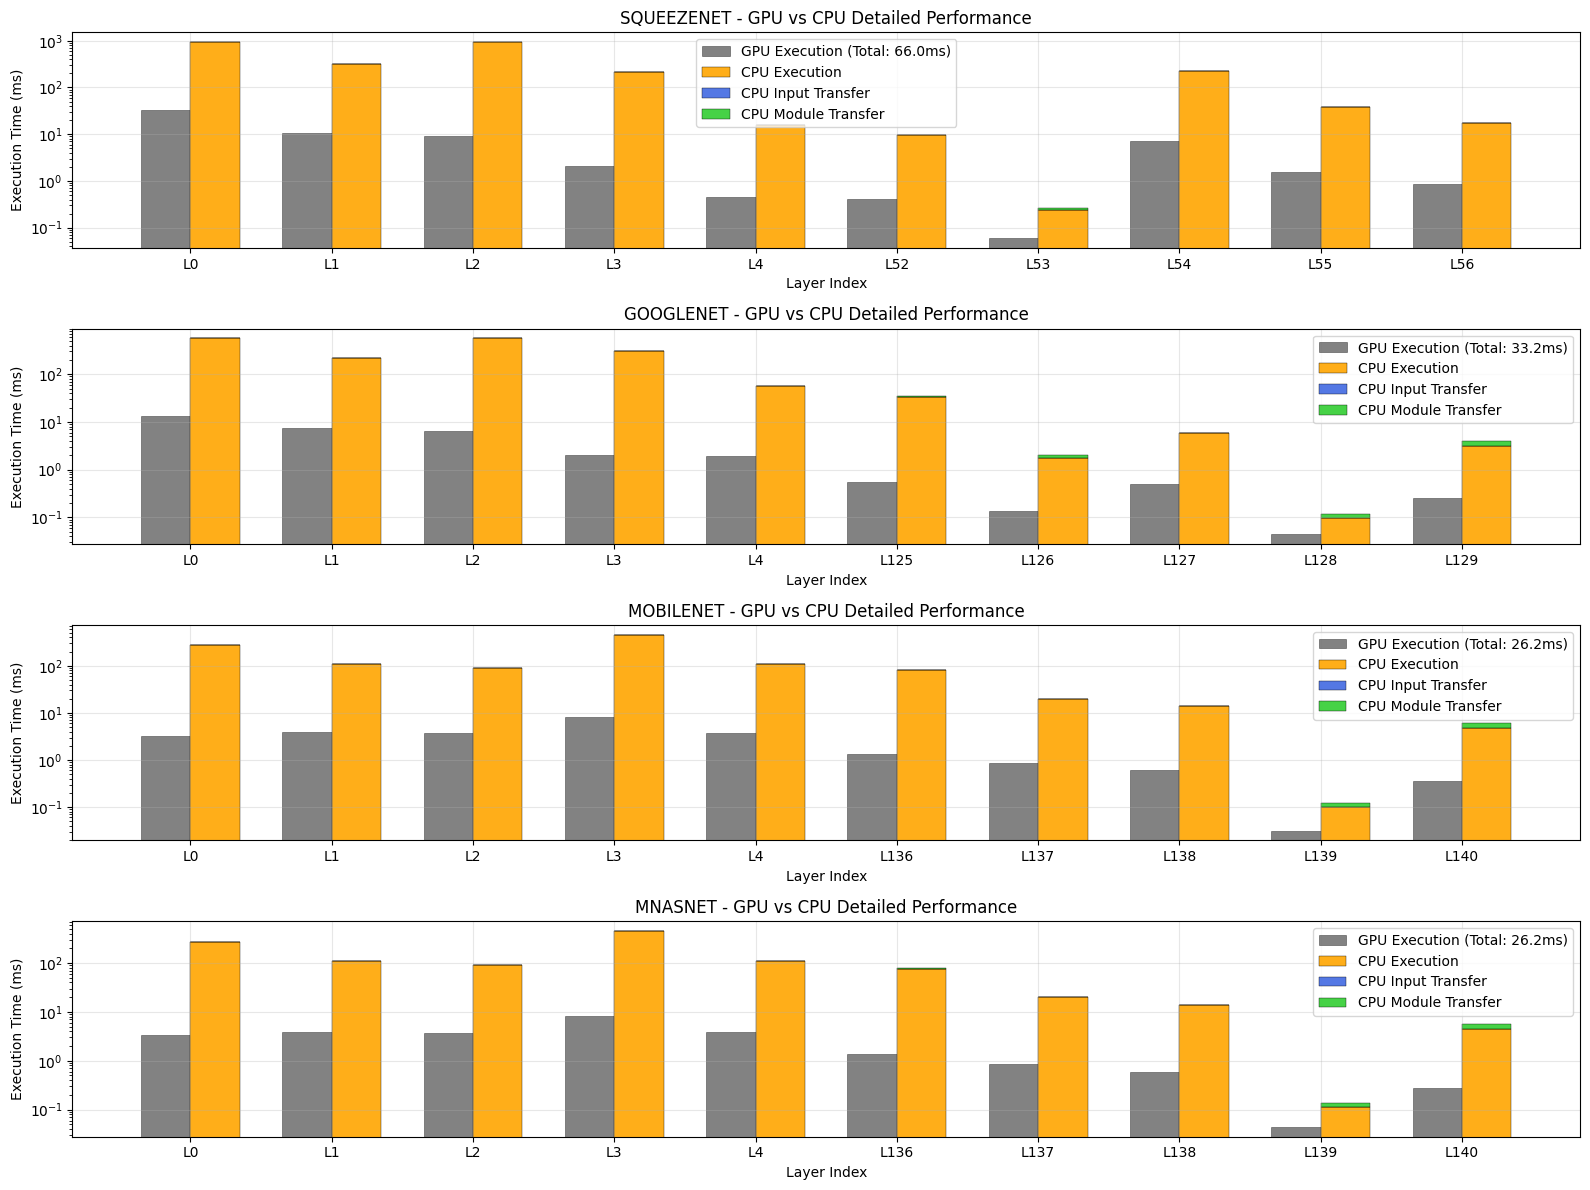


💾 Results saved to: /workspace/pytorch_bootcamp/results/stacked_comparison_20_20250725_084303.png
✅ Stacked analysis completed!


In [23]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx] 

    # 실행 시간 추출
    gpu_exec_times = []
    input_transfer_times = []
    module_transfer_times = []
    cpu_exec_times = []
    
    layer_names = []
    
    # 데이터 추출 - 순서대로 정렬
    layer_data = {}
    
    # GPU 실행 시간 추출
    for key, value in data['gpu'].items():
        if 'execution_time' in key:
            layer_idx = int(key.split('_')[1])
            layer_data[layer_idx] = layer_data.get(layer_idx, {})
            layer_data[layer_idx]['gpu_exec'] = value['time_ms']
    
    # CPU 시간 추출 
    for key, value in data['cpu'].items():
        layer_idx = int(key.split('_')[1])
        layer_data[layer_idx] = layer_data.get(layer_idx, {})
        
        if 'input_memory_transfer' in key:
            layer_data[layer_idx]['input_transfer'] = value['time_ms']
        elif 'execution_time' in key:
            layer_data[layer_idx]['cpu_exec'] = value['time_ms']
        elif 'module_transfer' in key:
            layer_data[layer_idx]['module_transfer'] = value['time_ms']
    
    # 순서대로 정렬하여 리스트 생성 (처음 5개 + 마지막 5개만)
    sorted_indices = sorted(layer_data.keys())

    # 처음 5개 + 마지막 5개 인덱스 추출
    selected_indices = sorted_indices[:5] + sorted_indices[-5:] if len(sorted_indices) > 10 else sorted_indices

    # 해당 인덱스에 대해만 그래프 데이터 저장
    for layer_idx in selected_indices:
        data_point = layer_data[layer_idx]
        gpu_exec_times.append(data_point.get('gpu_exec', 0))
        input_transfer_times.append(data_point.get('input_transfer', 0))
        cpu_exec_times.append(data_point.get('cpu_exec', 0))
        module_transfer_times.append(data_point.get('module_transfer', 0))
        layer_names.append(f"L{layer_idx}")
    
    # 총 실행 시간 계산
    gpu_total_time = sum(gpu_exec_times)
    
    # 막대 그래프
    x = np.arange(len(layer_names))
    width = 0.35
    
    # GPU는 단일 막대 
    bars1 = ax.bar(x - width/2, gpu_exec_times, width, label=f'GPU Execution (Total: {gpu_total_time:.1f}ms)', 
                    color="#070707", alpha=0.5, edgecolor='black', linewidth=0.5)

    # CPU 스택 막대 
    bars2 = ax.bar(x + width/2, cpu_exec_times, width, label='CPU Execution', 
                    color='#FFA500', alpha=0.9, edgecolor='black', linewidth=0.3) 
    bars3 = ax.bar(x + width/2, input_transfer_times, width, bottom=cpu_exec_times, 
                    label='CPU Input Transfer', color='#4169E1', alpha=0.9, edgecolor='black', linewidth=0.3)  
    bars4 = ax.bar(x + width/2, module_transfer_times, width, 
                    bottom=np.array(input_transfer_times) + np.array(cpu_exec_times), label='CPU Module Transfer', color='#32CD32', alpha=0.9, edgecolor='black', linewidth=0.3)

    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - GPU vs CPU Detailed Performance')
    ax.set_xticks(x[::max(1, len(x)//10)])  # x축 라벨 간소화
    ax.set_xticklabels([layer_names[i] for i in range(0, len(layer_names), max(1, len(x)//10))])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # 로그 스케일
    
plt.tight_layout()

# 저장 및 표시
save_path = f'/workspace/pytorch_bootcamp/results/stacked_comparison_20_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print(f"\n💾 Results saved to: {save_path}")
print("✅ Stacked analysis completed!")



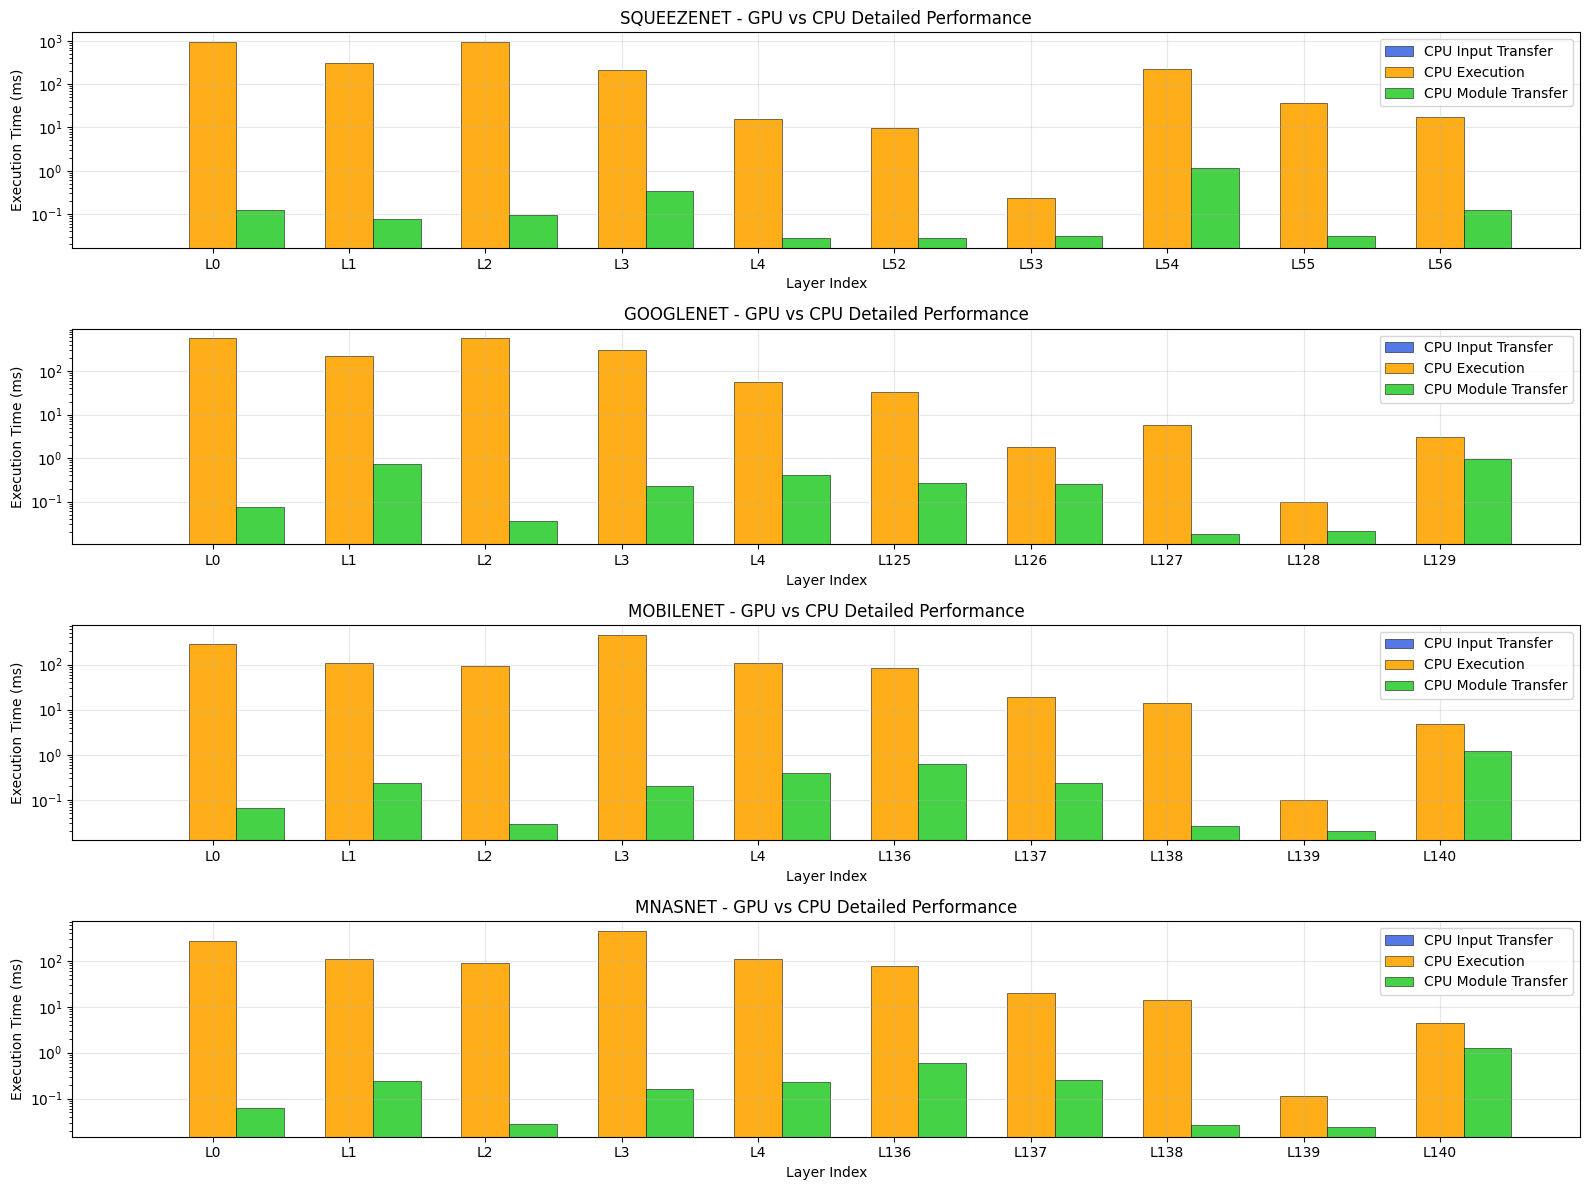


💾 Results saved to: /workspace/pytorch_bootcamp/results/stacked_comparison_20_20250725_084306.png
✅ Stacked analysis completed!


In [24]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx] 

    # 실행 시간 추출
    gpu_exec_times = []
    input_transfer_times = []
    module_transfer_times = []
    cpu_exec_times = []
    
    layer_names = []
    
    # 데이터 추출 - 순서대로 정렬
    layer_data = {}
    
    # GPU 실행 시간 추출
    for key, value in data['gpu'].items():
        if 'execution_time' in key:
            layer_idx = int(key.split('_')[1])
            layer_data[layer_idx] = layer_data.get(layer_idx, {})
            layer_data[layer_idx]['gpu_exec'] = value['time_ms']
    
    # CPU 시간 추출 
    for key, value in data['cpu'].items():
        layer_idx = int(key.split('_')[1])
        layer_data[layer_idx] = layer_data.get(layer_idx, {})
        
        if 'input_memory_transfer' in key:
            layer_data[layer_idx]['input_transfer'] = value['time_ms']
        elif 'execution_time' in key:
            layer_data[layer_idx]['cpu_exec'] = value['time_ms']
        elif 'module_transfer' in key:
            layer_data[layer_idx]['module_transfer'] = value['time_ms']
    
    # 순서대로 정렬하여 리스트 생성 (처음 5개 + 마지막 5개만)
    sorted_indices = sorted(layer_data.keys())

    # 처음 5개 + 마지막 5개 인덱스 추출
    selected_indices = sorted_indices[:5] + sorted_indices[-5:] if len(sorted_indices) > 10 else sorted_indices

    # 해당 인덱스에 대해만 그래프 데이터 저장
    for layer_idx in selected_indices:
        data_point = layer_data[layer_idx]
        gpu_exec_times.append(data_point.get('gpu_exec', 0))
        input_transfer_times.append(data_point.get('input_transfer', 0))
        cpu_exec_times.append(data_point.get('cpu_exec', 0))
        module_transfer_times.append(data_point.get('module_transfer', 0))
        layer_names.append(f"L{layer_idx}")
    
    # 총 실행 시간 계산
    gpu_total_time = sum(gpu_exec_times)
    
    # 막대 그래프
    x = np.arange(len(layer_names))
    width = 0.35

    bars_input = ax.bar(x - width, input_transfer_times, width, label='CPU Input Transfer',
                        color='#4169E1', alpha=0.9, edgecolor='black', linewidth=0.4)
    bars_exec = ax.bar(x, cpu_exec_times, width, label='CPU Execution', 
                        color='#FFA500', alpha=0.9, edgecolor='black', linewidth=0.4)
    bars_output = ax.bar(x + width, module_transfer_times, width, label='CPU Module Transfer',
                        color='#32CD32', alpha=0.9, edgecolor='black', linewidth=0.4)

    
    # 그래프 설정
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Execution Time (ms)')
    ax.set_title(f'{model_name.upper()} - GPU vs CPU Detailed Performance')
    ax.set_xticks(x[::max(1, len(x)//10)])  # x축 라벨 간소화
    ax.set_xticklabels([layer_names[i] for i in range(0, len(layer_names), max(1, len(x)//10))])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # 로그 스케일
    
plt.tight_layout()

# 저장 및 표시
save_path = f'/workspace/pytorch_bootcamp/results/stacked_comparison_20_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print(f"\n💾 Results saved to: {save_path}")
print("✅ Stacked analysis completed!")



In [16]:
# input을 옮길때와 output을 옮길 때의 시간 비교


In [17]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  64
  On-line CPU(s) list:   0-63
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Gold 6226R CPU @ 2.90GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  16
    Socket(s):           2
    Stepping:            7
    CPU max MHz:         3900.0000
    CPU min MHz:         1200.0000
    BogoMIPS:            5800.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor d

In [18]:
import torch, time
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

torch.backends.quantized.engine = "fbgemm"

In [19]:
models_quantized = {}

dummy_gpu  = torch.randn(1000, 3, 224, 224, device="cuda")
dummy_cpu  = dummy_gpu.cpu()                       
example_in = (torch.randn(1, 3, 224, 224),)      

# 아주 작은 캘리브레이션 배치 (1×3×224×224)
dummy_calib = torch.randn(1, 3, 224, 224)         

for name, model in models.items():
    model_copy = copy.deepcopy(model).eval()

    qdict = {"": get_default_qconfig("fbgemm")}
    prep  = prepare_fx(model_copy, qdict, example_in)    

    # 캘리브레이션 (더미 100번)
    with torch.inference_mode():
        for _ in range(100):
            prep(*example_in)
    qmodel = convert_fx(prep)
    models_quantized[name] = qmodel

quantized_results = {}
for name, model in models.items():
    # --- GPU ---
    m_gpu = copy.deepcopy(model).eval().to("cuda")
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.inference_mode():
        _ = m_gpu(dummy_gpu)
    torch.cuda.synchronize()
    t1 = time.time()
    quantized_results[name] = {'gpu': t1-t0}

    # --- CPU ---
    m_cpu = copy.deepcopy(model).eval().to("cpu")
    t2 = time.time()
    with torch.inference_mode():
        _ = m_cpu(dummy_cpu)
    t3 = time.time()
    quantized_results[name]['cpu'] = t3-t2

for name, model_quantized in models_quantized.items():

    # --- CPU quantized ---
    model_quantized = copy.deepcopy(model_quantized).eval().to("cpu")
    t2 = time.time()
    with torch.inference_mode():
        _ = model_quantized(dummy_cpu)
    t3 = time.time()
    quantized_results[name]['quantized'] = t3-t2


/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/ao/quantization/fx/prepare.py:1751: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(
/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/ao/quantization/fx/prepare.py:1751: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(
/root/miniconda3/envs/good/lib/python3.10/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.  

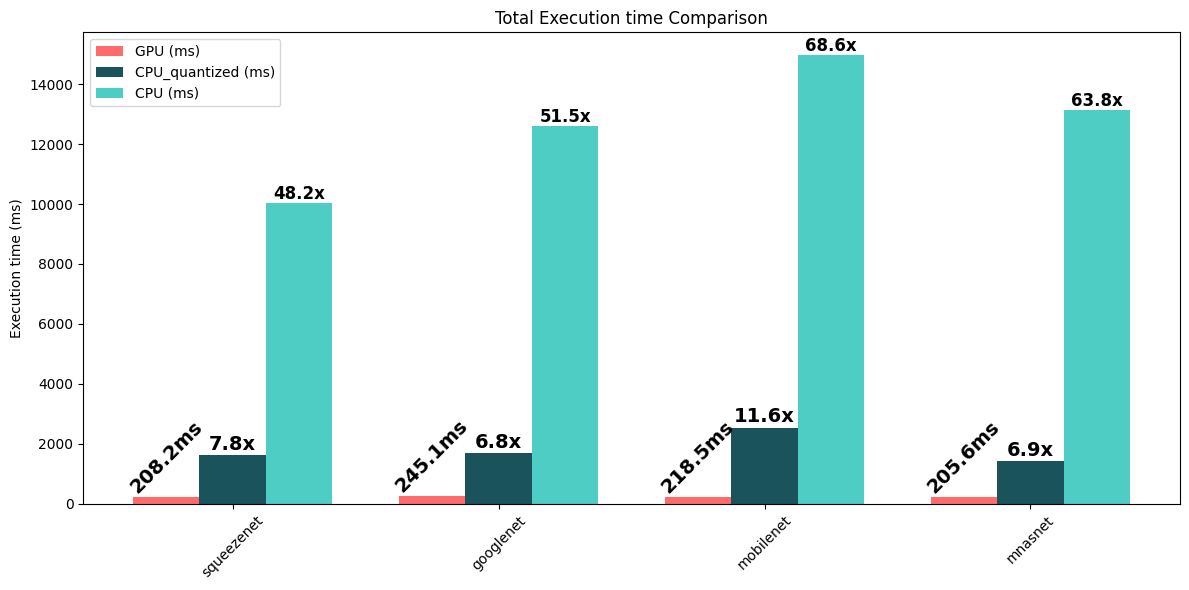

In [20]:
# ---------- Plot ----------
model_names = list(simple_results.keys())
gpu_times   = [quantized_results[k]['gpu']*1000 for k in model_names]
cpu_quantized = [quantized_results[k]['quantized']*1000 for k in model_names]
cpu_times   = [quantized_results[k]['cpu']*1000 for k in model_names]

x = np.arange(len(model_names))
w = 0.25  # 막대 폭을 줄여서 3개 막대가 잘 보이도록

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - w, gpu_times, width=w, label='GPU (ms)', color='#ff6b6b')
bars2 = plt.bar(x, cpu_quantized, width=w, label='CPU_quantized (ms)', color='#1a535c')
bars3 = plt.bar(x + w, cpu_times, width=w, label='CPU (ms)', color='#4ecdc4')

# GPU 실행 시간 라벨 달기
for i, (bar, gpu_time) in enumerate(zip(bars1, gpu_times)):
    height = bar.get_height()
    plt.text(x[i] - w, height*1.02, f"{gpu_time:.1f}ms",
             ha='center', va='bottom', fontsize=14, fontweight='bold', rotation=45)

# CPU Quantized 실행 시간 라벨 달기
for i, (bar, cpu_quantized_time) in enumerate(zip(bars2, cpu_quantized)):
    cpu_quantized_vs_gpu_slowdown = cpu_quantized[i] / gpu_times[i]
    height = bar.get_height()
    plt.text(x[i], height*1.02, f"{cpu_quantized_vs_gpu_slowdown:.1f}x",
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# CPU 실행 시간 라벨 달기
for i, (bar, cpu_time) in enumerate(zip(bars3, cpu_times)):
    cpu_vs_gpu_slowdown = cpu_times[i] / gpu_times[i]
    height = bar.get_height()
    plt.text(x[i] + w, height*1., f"{cpu_vs_gpu_slowdown:.1f}x",
             ha='center', va='bottom', fontsize=12, fontweight='bold',)

    
plt.xticks(x, model_names, rotation=45)
plt.ylabel('Execution time (ms)')
plt.title('Total Execution time Comparison')
plt.legend()
plt.tight_layout()
plt.show()